# Binary classification of commutative diagrams

In [1]:
import os
import shutil
import random
import math
import gc

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa # Needed for Yogi optimizer
tfa.register_all(custom_kernels=False) # Registers TFA objects in TF dictionaries
import matplotlib.pyplot as plt

from copy import deepcopy
from tensorflow import keras
from keras.preprocessing import image
from keras import layers
from keras import models
from keras.datasets import mnist
from gtts import gTTS

#%load_ext tensorboard
#%tensorboard --logdir TensorBoardLogs/

## Cockpit
Note that compiling a model implies not attempting to load it instead. (Models are automatically attempted loaded, but this feature is deactivated for the most part because EfficentNet models do not play nice with model saving and loading in the current stable release of TensorFlow.)

In [2]:
#### Manual parameters
# Data generation
unsortedSamplesDirName = 'diagramSamplesMarch25'

trainRatio = 0.6
testRatio = 0.2
valRatio = 0.2
assert(trainRatio + testRatio + valRatio == 1.)

positiveRatio = 0.5 # Desired ratio of positive samples in the sorted data


performCopy = False
runImageCopyTest = False
comparisonSampleSize = 50
imageFiletype = 'png'


globalBatchSize = 64
imageResolution = (203, 203)



# Baseline experiments
baselineTestingMode = False # Set this to true to test all baseline functions. Note that it currently doesn't test the less maintained MNIST functions.
doSerialTests = False

compileBaselineCNN = False
compileEfficientNetFE = True
compileFinetunedEfficientNet = False
compileMNISTEfficientNet = True # If this is True, the program will look for saved models for the categorical model (see the code block) and the frozen binary model, but assume that at least the hot binary model needs to be retrained.

# Filenames of saved models
baselineCNNModelName = 'baselineCNNSavedModel'
efficientNetFEModelName = 'efficientNetFESavedModel'
finetunedEfficientNetModelName = 'finetunedEfficientNetSavedModel'
MNISTEfficientNetModelName = 'MNISTEfficientNetSavedModel' # This will be the name of the final model.

metrics = [keras.metrics.BinaryAccuracy(), 
           keras.metrics.BinaryCrossentropy(), 
           keras.metrics.AUC(), 
           keras.metrics.Precision(), 
           keras.metrics.Recall()]#, tfa.metrics.F1Score(num_classes=2)]#
metricNames = ['binary accuracy', 'binary cross entropy', 
               'AUC', 'precision', 'recall'] # , 'F1']

globalEpochs = 20
globalFinetuningEpochs = 10


globalFinetuningLearningRate = 1e-5
layersToUnfreeze = ["top_bn", "top_conv", "block7b_project_bn", "block7b_project_conv", 
                    "block7a_project_bn", "block7a_project_conv"] #['top_conv', 'block7a_project_conv', 'block7a_dwconv']

useTensorBoard = False
useMNISTLogger = True


    
# Advanced experiments
advancedTestingMode = False # Set this to true to test all advanced experiments.

doLayerExperiment = False
doDatasetSizeExperiment = False
doBasicAugmentationsTest = False

blockwiseOutputLayers = ['block1b_add', 'block2c_add', 'block3c_add',
                         'block4d_add', 'block5d_add', 'block6e_add'] # For layer experiment
blockwiseEpochs = [40, 40, 40, 8, 7, 10]

sampleSizeWiseEpochs = [40, 40, 40, 40, 40, 40, 40, 8, 6]


#### Automated and deduced parameters

# Data pipeline
cwd = os.getcwd()
filesInCwd = os.listdir(cwd)
if useTensorBoard:
    tensorBoardCallback = keras.callbacks.TensorBoard(
        log_dir='TensorBoardLogs', histogram_freq=1, embeddings_freq=1)
    callbacks = [tensorBoardCallback] # Is this implemented correctly elsewhere in the code?
else:
    callbacks = None
    
if runImageCopyTest:
    performCopy = True

# Testing modes
if advancedTestingMode:
    doLayerExperiment = True
    doDatasetSizeExperiment = True
    
    #So and so = False
    
    blockwiseEpochs = [2, 2, 2, 2, 2, 2]
    sampleSizeWiseEpochs = [2, 2, 2, 2, 2, 2, 2, 2, 2]

if baselineTestingMode:
    compileBaselineCNN = True
    compileEfficientNetFE = True
    compileFinetunedEfficientNet = True
    compileMNISTEfficientNet = True
    
    globalEpochs = 2
    globalFinetuningEpochs = 2
    
    useTensorBoard = False
    useMNISTLogger = False
    
# Compiling prerequisite models
if compileFinetunedEfficientNet or doLayerExperiment or doDatasetSizeExperiment:
    compileEfficientNetFE = True
if compileMNISTEfficientNet or compileEfficientNetFE:
    compileEfficientNetBase = True
else:
    compileEfficientNetBase = False
if compileEfficientNetFE or compileMNISTEfficientNet:
    useFeatureExtraction = True
else:
    useFeatureExtraction = False    

Attempt to load any model not to be compiled  
**Currently not implemented, since Keras doesn't play nice with saved custom EfficientNets right now.**

In [3]:
"""
if not compileEfficientNetFE and efficientNetFEModelName in filesInCwd:
    efficientNetB1FEClassifier = models.load_model(efficientNetFEModelName)
    efficientNetB1FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                                       loss='binary_crossentropy',
                                       metrics=metrics)

if not compileBaselineCNN and baselineCNNModelName in filesInCwd:
    baselineCNN = models.load_model(baselineCNNModelName)
    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                        loss='binary_crossentropy',
                        metrics=metrics)

if not compileFinetunedEfficientNet and finetunedEfficientNetModelName in filesInCwd:
    finetunedEfficientNetB1 = models.load_model(finetunedEfficientNetModelName)
    finetunedEfficientNetB1.compile(optimizer=tfa.optimizers.Yogi(learning_rate=globalFinetuningLearningRate),
                                    loss='binary_crossentropy',
                                    metrics=metrics)

if not compileMNISTEfficientNet and MNISTEfficientNetModelName in filesInCwd:
    MNISTEfficientNetB1Binary = models.load_model(MNISTEfficientNetModelName)
    MNISTEfficientNetB1Binary.compile(optimizer=tfa.optimizers.Yogi(learning_rate=globalFinetuningLearningRate),
                                       loss='binary_crossentropy',
                                       metrics=metrics)
"""

"\nif not compileEfficientNetFE and efficientNetFEModelName in filesInCwd:\n    efficientNetB1FEClassifier = models.load_model(efficientNetFEModelName)\n    efficientNetB1FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),\n                                       loss='binary_crossentropy',\n                                       metrics=metrics)\n\nif not compileBaselineCNN and baselineCNNModelName in filesInCwd:\n    baselineCNN = models.load_model(baselineCNNModelName)\n    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),\n                        loss='binary_crossentropy',\n                        metrics=metrics)\n\nif not compileFinetunedEfficientNet and finetunedEfficientNetModelName in filesInCwd:\n    finetunedEfficientNetB1 = models.load_model(finetunedEfficientNetModelName)\n    finetunedEfficientNetB1.compile(optimizer=tfa.optimizers.Yogi(learning_rate=globalFinetuningLearningRate),\n                                    loss='binary_crossentropy',\n                     

## 1. Data pipeline

### 1.1 Expand working directory with train, test and validation folders

In [4]:
unsortedSamplesDir = os.path.join(cwd, unsortedSamplesDirName)
assert('positive' in os.listdir(unsortedSamplesDir) 
       and 'negative' in os.listdir(unsortedSamplesDir))
unsortedPositiveSamplesDir = os.path.join(unsortedSamplesDir, 'positive')
unsortedNegativeSamplesDir = os.path.join(unsortedSamplesDir, 'negative')

sortedSamplesDir = os.path.join(cwd, 'sortedSamples')
os.makedirs(sortedSamplesDir, exist_ok=True)

trainDir = os.path.join(sortedSamplesDir, 'train')
testDir = os.path.join(sortedSamplesDir, 'test')
valDir = os.path.join(sortedSamplesDir, 'val')
os.makedirs(trainDir, exist_ok=True)
os.makedirs(testDir, exist_ok=True)
os.makedirs(valDir, exist_ok=True)

trainPositiveDir = os.path.join(trainDir, 'positive')
trainNegativeDir = os.path.join(trainDir, 'negative')
testPositiveDir = os.path.join(testDir, 'positive')
testNegativeDir = os.path.join(testDir, 'negative')
valPositiveDir = os.path.join(valDir, 'positive')
valNegativeDir = os.path.join(valDir, 'negative')
os.makedirs(trainPositiveDir, exist_ok=True)
os.makedirs(trainNegativeDir, exist_ok=True)
os.makedirs(testPositiveDir, exist_ok=True)
os.makedirs(testNegativeDir, exist_ok=True)
os.makedirs(valPositiveDir, exist_ok=True)
os.makedirs(valNegativeDir, exist_ok=True)

### 1.2 Copy images into folders
The code currently randomly truncates the greater partition between positive and negative to achieve parity.

In [5]:
if performCopy:
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)
    random.shuffle(positiveSamplesFilenameList)
    random.shuffle(negativeSamplesFilenameList)
    numPositiveSamples = len(positiveSamplesFilenameList)
    numNegativeSamples = len(negativeSamplesFilenameList)

    if numPositiveSamples > numNegativeSamples:
        positiveSamplesFilenameList = positiveSamplesFilenameList[:numNegativeSamples]
        numPositiveSamples = len(positiveSamplesFilenameList)
    elif numNegativeSamples > numPositiveSamples:
        negativeSamplesFilenameList = negativeSamplesFilenameList[:numPositiveSamples]
        numNegativeSamples = len(negativeSamplesFilenameList)
    assert(numPositiveSamples == numNegativeSamples)

    numSamples = numPositiveSamples + numNegativeSamples

    numTrainSamples = math.floor(numSamples*trainRatio)
    numTestSamples = math.floor(numSamples*testRatio)
    numValSamples = math.floor(numSamples*valRatio)


    unsortedSamplesInfo = {'posDir':unsortedPositiveSamplesDir, 
                           'negDir':unsortedNegativeSamplesDir, 
                           'posFilenameList':positiveSamplesFilenameList, 
                           'negFilenameList':negativeSamplesFilenameList}

    trainCopyInfo = {'num':numTrainSamples, 'posDir':trainPositiveDir, 'negDir':trainNegativeDir}
    testCopyInfo = {'num':numTestSamples, 'posDir':testPositiveDir, 'negDir':testNegativeDir}
    valCopyInfo = {'num':numValSamples, 'posDir':valPositiveDir, 'negDir':valNegativeDir}

    def copyImagesInPartition(unsortedSamplesInfo:dict, partitionCopyInfo:dict):
        for _ in range(math.floor(partitionCopyInfo['num']*positiveRatio)):
            copyImage(unsortedSamplesInfo['posFilenameList'], 
                      unsortedSamplesInfo['posDir'], 
                      partitionCopyInfo['posDir'])
        for _ in range(math.floor(partitionCopyInfo['num']*(1. - positiveRatio))):
            copyImage(unsortedSamplesInfo['negFilenameList'], 
                      unsortedSamplesInfo['negDir'], 
                      partitionCopyInfo['negDir'])

    def copyImage(sampleFilenameList, srcDir, dstDir):
        filename = sampleFilenameList.pop()
        src = os.path.join(srcDir, filename)
        dst = os.path.join(dstDir, filename)
        try:
            shutil.copyfile(src, dst)
        except PermissionError: # Ignores straggler files such as notebook checkpoints
            pass

    sampleDirectorySizes = [len(directory) for directory in [
        os.listdir(trainPositiveDir), os.listdir(trainNegativeDir), 
        os.listdir(testPositiveDir), os.listdir(testNegativeDir),
        os.listdir(testPositiveDir), os.listdir(testNegativeDir)]]

    if all(size == 0 for size in sampleDirectorySizes):
        copyImagesInPartition(unsortedSamplesInfo, trainCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, testCopyInfo)
        copyImagesInPartition(unsortedSamplesInfo, valCopyInfo)
    else:
        raise Exception("Sorted image directories are not empty.")

[*Optional*]: Test whether a sample handful of the images were copied to the correct folders

In [6]:
if runImageCopyTest:
    # These must be redefined here since they were popped
    positiveSamplesFilenameList = os.listdir(unsortedPositiveSamplesDir)
    negativeSamplesFilenameList = os.listdir(unsortedNegativeSamplesDir)

    sortedTrainPositiveFilenameList = os.listdir(trainPositiveDir)
    sortedTrainNegativeFilenameList = os.listdir(trainNegativeDir)
    sortedTestPositiveFilenameList = os.listdir(testPositiveDir)
    sortedTestNegativeFilenameList = os.listdir(testNegativeDir)
    sortedValPositiveFilenameList = os.listdir(valPositiveDir)
    sortedValNegativeFilenameList = os.listdir(valNegativeDir)
    random.shuffle(sortedTrainPositiveFilenameList)
    random.shuffle(sortedTrainNegativeFilenameList)
    random.shuffle(sortedTestPositiveFilenameList)
    random.shuffle(sortedTestNegativeFilenameList)
    random.shuffle(sortedValPositiveFilenameList)
    random.shuffle(sortedValNegativeFilenameList)

    allPositiveFilenameLists = [sortedTrainPositiveFilenameList, 
                                sortedTestPositiveFilenameList, 
                                sortedValPositiveFilenameList]
    allNegativeFilenameLists = [sortedTrainNegativeFilenameList, 
                                sortedTestNegativeFilenameList, 
                                sortedValNegativeFilenameList]

    def matchesImageFiletype(sampleFilename : str, imageFiletype : str): # Needed to ignore straggler files such as notebook checkpoints
        return sampleFilename[:len(imageFiletype)] == imageFiletype

    for fList in allPositiveFilenameLists:
        assert(all(sampleFilename in positiveSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    for fList in allNegativeFilenameLists:
        assert(all(sampleFilename in negativeSamplesFilenameList
                   for sampleFilename in fList[:comparisonSampleSize]
                   if matchesImageFiletype(sampleFilename, imageFiletype)))
    print('Test was succesful!')

### 1.3 Data generators

The data generators themselves can rescale the input pixel values to the [0, 1] range, to grayscale and perform common augmentation techniques. 

- Data is normalized to the [0, 1] range and converted to grayscale for the baseline CNN
- The EfficientNet models expect 3D pixel floats in the [0-255] range, so these are not normalized.
- EfficientNet models pre-trained on ImageNet expect colored inputs, but this is not mandatory for untrained EfficientNet. Thus, grayscale is used for the MNIST model.

In [7]:
def doGeneratorTest(dataGenerator):
    print("Performing generator test.")
    testImgPath = "C:\\Users\\gottk\\Documents\\Skolerelateret\\Universitet\\Bachelor\\testImg.png"
    img = image.load_img(testImgPath, target_size=(203, 203))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in dataGenerator.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 4 == 0:
            break
    plt.show()

In [8]:
def produceDataGenerators(colorMode='rgb', rescale=None, imageResolution=imageResolution, 
                          batchSize=globalBatchSize, 
                          preprocessingFunction = None,
                          testingMode = False,
                          augmentations = {'rotation_range':0, 
                                           'width_shift_range':0.0, 
                                           'height_shift_range':0.0,
                                           'shear_range':0.0, 
                                           'zoom_range':0.0,
                                           'horizontal_flip':False, 
                                           'vertical_flip':False},
                         produceFactory = False):
    assert(colorMode in ['rgb', 'grayscale'])
    dataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = preprocessingFunction,
        rotation_range = augmentations['rotation_range'], 
        width_shift_range = augmentations['width_shift_range'], 
        height_shift_range = augmentations['height_shift_range'],
        shear_range = augmentations['shear_range'], 
        zoom_range = augmentations['zoom_range'],
        horizontal_flip = augmentations['horizontal_flip'], 
        vertical_flip = augmentations['vertical_flip'],
        rescale = rescale)
    if testingMode:
        doGeneratorTest(dataGeneratorFactory)
    
    trainDataGenerator = dataGeneratorFactory.flow_from_directory(
        trainDir,
        target_size = imageResolution,
        batch_size = batchSize,
        color_mode = colorMode,
        class_mode = 'binary')
    testDataGenerator = dataGeneratorFactory.flow_from_directory(
        testDir,
        target_size = imageResolution,
        batch_size = batchSize,
        color_mode = colorMode,
        class_mode = 'binary')
    valDataGenerator = dataGeneratorFactory.flow_from_directory(
        valDir,
        target_size = imageResolution,
        batch_size = batchSize,
        color_mode = colorMode,
        class_mode = 'binary')
    if produceFactory:
        return dataGeneratorFactory, {'train':trainDataGenerator, 'test':testDataGenerator, 'val':valDataGenerator}
    else:
        return {'train':trainDataGenerator, 'test':testDataGenerator, 'val':valDataGenerator}

if compileBaselineCNN:
    baselineCNNGenerators = produceDataGenerators(colorMode='grayscale', rescale=1./255)
if compileEfficientNetBase:
    efficientNetColorGenerators = produceDataGenerators(colorMode='rgb')
if compileMNISTEfficientNet:
    efficientNetGrayscaleGenerators = produceDataGenerators(colorMode='grayscale')

Found 1292 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 1292 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


## 2 Baseline models implementation
A series of baseline models are implemented for comparative study.
- A simple vanilla CNN model with a standard architecture
- Pretrained EfficientNet as feature extraction
- Finetuned pretrained EfficientNet
- EfficientNet manually trained on MNIST

Note that compiling the finetuned EfficientNet or the MNIST EfficientNet requires a feature extractor, and the process will fail if no saved model exists and compilation of the feature extractor is off.

Remember in the following that the 'EfficientNet feature extraction classifier' acts as a full model when performing feature extraction, in which case it cooperates with the frozen EfficientNet base, which is also a discrete model. However, if used in finetuning, both models are combined and the full model is named the 'Finetuning model'.

Note that all test-score dictionary objects are not currently used, and write to CSV-files anyway, but I bind them in the code anyway in case I want to use them later.

### 2.1 Building the models

In [9]:
def zipMetricsKeysWithNames(keys, metricNames):
    metricKeys = list(keys)
    metricKeysTrainingOnly = metricKeys[1:len(metricKeys) // 2] # Ignores the generic loss metric and truncates all validation histories
    assert(len(metricNames) == len(metricKeysTrainingOnly))
    zippedMetrics = zip(metricKeysTrainingOnly, metricNames)
    return zippedMetrics

def plotTrainingHistories(history, metricsKeysNamesZip, modelName:str):
    for (key, name) in metricsKeysNamesZip:
        metricHistory = history.history[key]
        metricValHistory = history.history[f'val_{key}']
        plotOneTrainingHistory(metricHistory, metricValHistory, name, modelName)

def plotOneTrainingHistory(metricHistory, 
                           metricValHistory, 
                           metricName, 
                           modelName):
    plt.figure(figsize=(6.4, 4.8))
    numEpochs = len(metricHistory)
    epochsRange = range(1, math.floor(numEpochs + 1))
    plt.plot(epochsRange, 
             metricHistory, 
             'bo', 
             label=f'Training {metricName}')
    plt.plot(epochsRange, 
             metricValHistory, 
             'r', 
             label=f'Validation {metricName}')
    
    botLim, topLim = plt.ylim()
    axisScale = np.abs(topLim - botLim)
    
    # Scan for outliers
    stepwiseDifferences = np.abs(
        np.array(metricHistory[1:]) - np.array(metricHistory[:-1]))
    medianStepDifference = np.median(stepwiseDifferences)
    stepwiseValDifferences = np.abs(
        np.array(metricValHistory[1:]) - np.array(metricValHistory[:-1]))
    medianValStepDifference = np.median(stepwiseDifferences)
    
    if 10*medianStepDifference > 10*medianValStepDifference:
        stepDifferenceBound = 10*medianStepDifference
        medianValue = np.median(metricHistory)
    else:
        stepDifferenceBound = 10*medianValStepDifference
        medianValue = np.median(metricValHistory)
    
    if axisScale > stepDifferenceBound: # prevent the vertical scale from being too great
        if np.max(np.array(metricHistory)) < 10 and np.min(np.array(metricHistory)) > 0:
            botLim = np.max([0, medianValue - 10*medianStepDifference])
            topLim = np.min([10, medianValue + 10*medianStepDifference])
        else:
            botLim = medianValue - 10*medianStepDifference
            topLim = medianValue + 10*medianStepDifference
        plt.ylim(botLim, topLim)
    elif axisScale < 0.06: # Prevent the vertical scale from being too close
        padding = 0.06 - axisScale
        botLim -= padding / 2
        topLim += padding / 2
        plt.ylim(botLim, topLim)
        
    plt.xlabel('Epoch')
    plt.ylabel(metricName)
    plt.title(f'Training and validation {metricName} for {modelName}')
    plt.legend()
    shortModelName = shortenModelOrMetricName(modelName)
    shortMetricName = shortenModelOrMetricName(metricName)
    plt.savefig(f'{shortModelName}{shortMetricName}{numEpochs}Epochs.jpeg', 
                transparent=False, 
                bbox_inches='tight')

def shortenModelOrMetricName(modelOrMetricName:str):
    return modelOrMetricName.title().replace(' ','')

#### 2.1.1 Baseline CNN

In [10]:
def buildBaselineCNN(dataGenerators, epochs = 6, inputShape = (*imageResolution, 1), batchSize = globalBatchSize): #  = baselineCNNGenerators
    baselineCNN = models.Sequential(name='BaselineCNN')
    baselineCNN.add(layers.Conv2D(32, 
                                  (3, 3), 
                                  activation='relu', 
                                  input_shape=inputShape))
    
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Flatten())
    baselineCNN.add(layers.Dropout(0.5))
    baselineCNN.add(layers.Dense(512, activation='relu'))
    baselineCNN.add(layers.Dense(1, activation='sigmoid'))
    
    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                        loss='binary_crossentropy',
                        metrics=metrics)
    baselineCNNHistory = baselineCNN.fit(dataGenerators['train'],
                                         epochs=epochs, # globalEpochs
                                         batch_size=batchSize,
                                         validation_data=dataGenerators['val'],
                                         callbacks=callbacks)
    baselineCNN.save(baselineCNNModelName)
    keras.utils.plot_model(baselineCNN,
                           to_file='baselineCNN.jpg',
                           show_shapes=True)
    
    print("Now testing:")
    baselineCNNTestScores = baselineCNN.evaluate(
            dataGenerators['test'], 
            batch_size=batchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('BaselineCNNTestLog.csv')])
    return baselineCNN, baselineCNNHistory, baselineCNNTestScores


if compileBaselineCNN:
    gTTS(text="Starting training of Baseline CNN").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")

    baselineCNN = models.Sequential(name='BaselineCNN')
    baselineCNN.add(layers.Conv2D(32, 
                                  (3, 3), 
                                  activation='relu', 
                                  input_shape=(*imageResolution, 1)))
    
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    baselineCNN.add(layers.MaxPooling2D((2,2)))
    baselineCNN.add(layers.Flatten())
    baselineCNN.add(layers.Dropout(0.5))
    baselineCNN.add(layers.Dense(512, activation='relu'))
    baselineCNN.add(layers.Dense(1, activation='sigmoid'))
    
    baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                        loss='binary_crossentropy',
                        metrics=metrics)
    baselineCNNHistory = baselineCNN.fit(baselineCNNGenerators['train'],
                                         epochs=6, # globalEpochs
                                         batch_size=globalBatchSize,
                                         validation_data=baselineCNNGenerators['val'],
                                         callbacks=callbacks)
    baselineCNN.save(baselineCNNModelName)
    keras.utils.plot_model(baselineCNN,
                           to_file='baselineCNN.jpg',
                           show_shapes=True)
    
    print("Now testing:")
    baselineCNNTestScores = baselineCNN.evaluate(
            baselineCNNGenerators['test'], 
            batch_size=globalBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('BaselineCNNTestLog.csv')])

#### 2.1.2 Feature extraction

Load the base

In [11]:
def buildEfficientNetBase(inputShape=(*imageResolution, 3), weights='imagenet'):
    efficientNetB1Base = keras.applications.efficientnet.EfficientNetB1(
        include_top = False,
        input_shape = inputShape,
        # Try with pooling='avg'/'max'?
        weights = weights)
    if weights:
        efficientNetB1Base.trainable = False
    return efficientNetB1Base
    
if compileEfficientNetBase:
    efficientNetB1Base = buildEfficientNetBase()

Feature extraction functions

In [12]:
def extractFeatureSets(model, generators:dict, batchSize=globalBatchSize, numSamplesList=[None, None, None]):
    """
    PARAMETERS:
        model - Pre-trained model base
        generators - dict of data generators
    RETURNS: Dict of pairs of arrays of feature maps and labels
    """
    #gTTS(text="Extracting EfficientNet features.").save('TTSTick.mp3')
    #os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    
    baseFlatOutputSize = np.product(model.output_shape[1:])
    
    efficientNetTrainFeatures, efficientNetTrainLabels = extractFeatures(
        model, 
        generators['train'],
        batchSize=batchSize,
        numSamples=numSamplesList[0])
    efficientNetTestFeatures, efficientNetTestLabels = extractFeatures(
        model, 
        generators['test'],
        batchSize=batchSize,
        numSamples=numSamplesList[1])
    efficientNetValFeatures, efficientNetValLabels = extractFeatures(
        model, 
        generators['val'],
        batchSize=batchSize,
        numSamples=numSamplesList[2])

    efficientNetTrainFeatures = np.reshape(
        efficientNetTrainFeatures, 
        (efficientNetTrainFeatures.shape[0], baseFlatOutputSize))
    efficientNetTestFeatures = np.reshape(
        efficientNetTestFeatures, 
        (efficientNetTestFeatures.shape[0], baseFlatOutputSize))
    efficientNetValFeatures = np.reshape(
        efficientNetValFeatures, 
        (efficientNetValFeatures.shape[0], baseFlatOutputSize))
    return {'train':(efficientNetTrainFeatures, efficientNetTrainLabels),
            'test':(efficientNetTestFeatures, efficientNetTestLabels),
            'val':(efficientNetValFeatures, efficientNetValLabels)}


def extractFeatures(model, generator, batchSize=globalBatchSize, numSamples=None):
    modelOutputShape = model.output_shape[1:]
    if not numSamples:
        numSamples = generator.n
    numSamples -= (numSamples % batchSize) # Truncate shape of output samples to fit batchsize
    
    features = np.zeros(shape=(numSamples, *modelOutputShape))
    labels = np.zeros(shape=(numSamples))
    i = 0
    for inputBatch, labelBatch in generator:
        # Uncomment to visualize an intermediate output.
        ### 
        """
        if i % 5 == 0:
            j = 1
            #while j < 5:
            plt.figure(j)
            imgplot = plt.imshow(image.array_to_img(inputBatch[0]))
            #
            j += 1
            plt.show()
        """
        featureBatch = model.predict(inputBatch)
        features[i*batchSize : (i + 1)*batchSize] = featureBatch
        labels[i*batchSize : (i + 1)*batchSize] = labelBatch
        i += 1
        if i*batchSize >= numSamples:
            break
    return features, labels

if useFeatureExtraction:
    colorFeatureSets = extractFeatureSets(efficientNetB1Base, efficientNetColorGenerators)

##### 2.1.2.2 Feature-extraction classifier

Epoch 1/5
10/10 [==============================] - 2s 115ms/step - loss: 14.0308 - binary_accuracy: 0.9174 - binary_crossentropy: 1.4112 - auc: 0.8738 - precision: 0.7250 - recall: 0.3453 - val_loss: 2.7210 - val_binary_accuracy: 0.8750 - val_binary_crossentropy: 2.7210 - val_auc: 0.8873 - val_precision: 0.8757 - val_recall: 0.8663
Epoch 2/5
10/10 [==============================] - 1s 60ms/step - loss: 2.9142 - binary_accuracy: 0.8406 - binary_crossentropy: 2.9142 - auc: 0.8639 - precision: 0.8474 - recall: 0.8369 - val_loss: 0.4083 - val_binary_accuracy: 0.8776 - val_binary_crossentropy: 0.4083 - val_auc: 0.9500 - val_precision: 0.8933 - val_recall: 0.8503
Epoch 3/5
10/10 [==============================] - 0s 51ms/step - loss: 0.4991 - binary_accuracy: 0.8562 - binary_crossentropy: 0.4991 - auc: 0.9307 - precision: 0.8317 - recall: 0.8653 - val_loss: 0.2636 - val_binary_accuracy: 0.8932 - val_binary_crossentropy: 0.2636 - val_auc: 0.9586 - val_precision: 0.8380 - val_recall: 0.9679
Ep

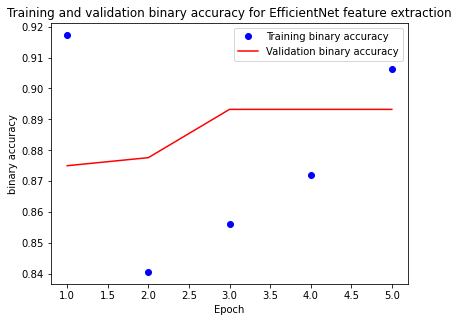

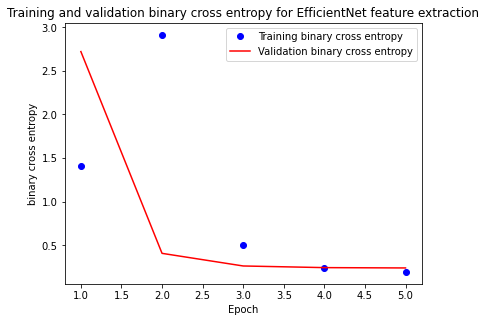

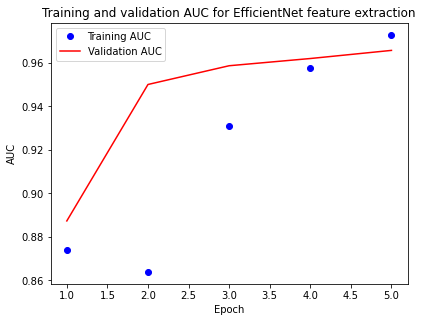

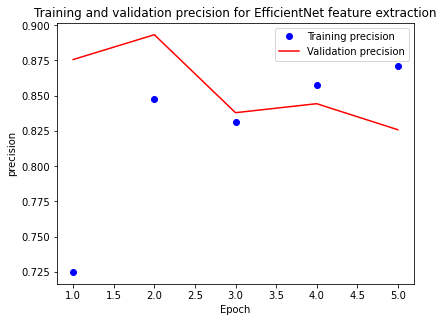

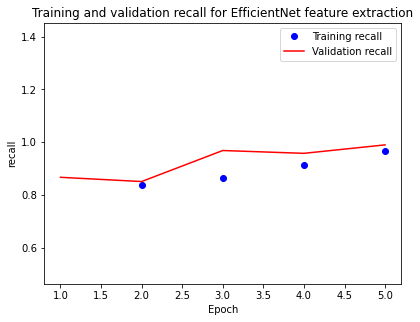

6/6 [==============================] - 0s 21ms/step - loss: 0.1913 - binary_accuracy: 0.9245 - binary_crossentropy: 0.1913 - auc: 0.9733 - precision: 0.8700 - recall: 1.0000


In [18]:
def buildFeatureExtractionClassifier(featureSets=colorFeatureSets, 
                                     baseModel=efficientNetB1Base, 
                                     modelName=None, 
                                     epochs=globalEpochs,
                                     batchSize=globalBatchSize,
                                     labelSmoothing=None,
                                     verbose=False):
    """
    Include a model name to save and draw the model!
    Enter labelSmoothing as the upper bound float on the label smoothing intensity [0., 1.]
    RETURNS: The fit feature extraction classifier, its History object and its test scores object.
    """
    if verbose:
        gTTS(text="Compiling feature extraction classifier").save('TTSTick.mp3')
        os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    
    baseFlatOutputSize = np.product(baseModel.output_shape[1:])
    
    FEClassifier = models.Sequential(name=modelName)
    FEClassifier.add(layers.Dense(256, 
                                  activation='relu', 
                                  input_dim=baseFlatOutputSize))
    
    FEClassifier.add(layers.Dropout(0.5))
    FEClassifier.add(layers.Dense(1, activation='sigmoid'))
    
    if labelSmoothing:
        labelSmoothingIntensity = np.random.uniform(high=labelSmoothing)
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=labelSmoothingIntensity)
    else:
        loss = 'binary_crossentropy'

    FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                                       loss=loss,
                                       metrics=metrics)
    FEClassifierHistory = FEClassifier.fit(featureSets['train'][0], 
                                           featureSets['train'][1],
                                           epochs=epochs,
                                           batch_size=batchSize,
                                           validation_data=featureSets['val'],
                                           callbacks=callbacks,
                                           steps_per_epoch=10)
    if modelName:
        FEClassifier.save(modelName)
        keras.utils.plot_model(FEClassifier,
                               to_file=f'{modelName}.jpg',
                               show_shapes=True)
    print('Now testing feature extraction model:')
    
    metricsKeysNames = zipMetricsKeysWithNames(
            FEClassifierHistory.history.keys(), 
            metricNames)
    plotTrainingHistories(
            FEClassifierHistory, 
            metricsKeysNames, 
            'EfficientNet feature extraction')
    plt.show()
    
    efficientNetFETestScores = FEClassifier.evaluate(
        featureSets['test'][0],
        featureSets['test'][1], 
        batch_size=globalBatchSize, 
        return_dict=True,
        callbacks=[tf.keras.callbacks.CSVLogger('efficientNetFETestLog.csv')])
    return FEClassifier, FEClassifierHistory, efficientNetFETestScores

if compileEfficientNetFE:
    efficientNetB1FEClassifier, efficientNetB1FEClassifierHistory, efficientNetB1FEClassifierTestScores = buildFeatureExtractionClassifier(
        modelName='efficientNetB1FE', 
        epochs=5) # 4

In [14]:
def extractFeaturesAndBuildModel(modelBase, # Not used before augmentation experiments!
                                 dataGenerators, 
                                 modelName='AnonymousModel', 
                                 epochs=globalEpochs, 
                                 labelSmoothing=None,
                                 numSamplesList = [None, None, None],
                                 batchSize=globalBatchSize): # Enter labelSmoothing as a max-intensity float [0, 1]
    featureSets = extractFeatureSets(modelBase, 
                                     dataGenerators, 
                                     numSamplesList=numSamplesList,
                                     batchSize=batchSize)
    classifier, classifierHistory, testScores = buildFeatureExtractionClassifier(
        featureSets=featureSets,
        baseModel=modelBase,
        modelName=modelName, 
        epochs=epochs,
        labelSmoothing=labelSmoothing,
        batchSize = batchSize
    )
    return classifier, classifierHistory, testScores

#### 2.1.4 Finetuned EfficientNet

In [15]:
if compileFinetunedEfficientNet:
    def buildFinetunedEfficientNet(generators:dict, 
                                   baseModel=efficientNetB1Base, 
                                   classifier=efficientNetB1FEClassifier, 
                                   modelName=None, 
                                   layersToUnfreeze=layersToUnfreeze, 
                                   learningRate=0.0001):
        """
        Include a model name to save and draw the model!
        RETURNS: The fit finetuned model and its History object.
        """
        gTTS(text="Compiling finetuned EfficientNet").save('TTSTick.mp3')
        os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")

        trainableBase = baseModel
        trainableBase.trainable = True
        for layer in trainableBase.layers:
            if layer.name not in layersToUnfreeze:
                layer.trainable = False

        finetunedModel = models.Sequential(name=modelName)
        finetunedModel.add(trainableBase)
        finetunedModel.add(layers.Flatten())
        finetunedModel.add(classifier) # Note that this is already trained

        finetunedModel.compile(optimizer=tfa.optimizers.Yogi(learning_rate=learningRate), # globalFinetuningLearningRate
                                        loss='binary_crossentropy',
                                        metrics=metrics)
        finetunedModelHistory = finetunedModel.fit(
            efficientNetColorGenerators['train'],
            epochs=10,
            batch_size=globalBatchSize,
            validation_data=efficientNetColorGenerators['val'],
            callbacks=callbacks)

        """
        if modelName:
            finetunedModel.save(modelName)
            keras.utils.plot_model(finetunedModel,
                                   to_file=f'{modelName}.jpg',
                                   show_shapes=True)
        """
        
        print("Now testing finetuned model:")
        finetunedModelTestScores = finetunedModel.evaluate(
            efficientNetColorGenerators['test'], 
            batch_size=globalBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('finetunedEfficientNetTestLog.csv')])
        
        metricsKeysNames = zipMetricsKeysWithNames(
            finetunedModelHistory.history.keys(), 
            metricNames)
        plotTrainingHistories(
            finetunedModelHistory, 
            metricsKeysNames, 
            'Finetuned EfficientNet')
        plt.show()
        return finetunedModel, finetunedModelHistory

    finetunedEfficientNetB1, finetunedEfficientNetB1History = buildFinetunedEfficientNet(
        efficientNetColorGenerators, modelName='finetunedEfficientNetB1')

#### 2.1.5 MNIST EfficientNet model training function
Since these models take much longer to train than any of the other models, I restrict a checkpoint-based *trainOrResumeTraining* function to these models to avoid unnecessary checkpoint bookkeeping clutter. This also means the intermediate models are saved as seperate models with their own training histories, provided they are trained in one go.

(*This function is currently very handicapped and roughly no improvement over manual training calls, due to how the current version of TensorFlow struggles with saving and loading custom models and models with TF-Addons. Hence it is only minimally maintained. But it is kept since these issues are supposedly fixed in the newest nightly versions.*)

In [16]:
def trainOrResumeTrainingMNIST(model, 
                               samplesOrGenerator,
                               epochs, 
                               stepsPerEpoch=None,
                               labels=None, 
                               modelName=None, 
                               validationData=None):
    if modelName is None:
        modelName = model.name

    MNISTCallbacks = []
    if useTensorBoard:
        MNISTCallbacks.append(tensorBoardCallback)
    if useMNISTLogger:
        loggerCallback = tf.keras.callbacks.CSVLogger(modelName + 'Log.csv')
        MNISTCallbacks.append(loggerCallback)
    if len(MNISTCallbacks) == 0: # Delete once checkpoints are fixed
        MNISTCallbacks = None #
    """
    WARNING: THIS CODE IS NOT MAINTAINED
    
    checkpointCallback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelCkptDir, '{epoch}'), save_weights_only=True)
    MNISTCallbacks.append(checkpointCallback)
    CkptsAvailable = 'checkpoints' in os.listdir(cwd) and modelName in os.listdir(ckptsDir)
    if CkptsAvailable:
        epochNums = (int(filename.split('.')[0]) for filename in os.listdir(modelCkptDir) if filename.split('.')[0].isdigit())
        resumingEpoch = max(epochNums)
        assert(resumingEpoch < epochs)
        ckptPath = os.path.join(modelCkptDir, str(resumingEpoch))
        model.load_weights(ckptPath)
        print(f'Found checkpoint for {modelName}. Resuming training from epoch {resumingEpoch + 1}')
        history = model.fit(samplesOrGenerator, 
                            labels,
                            initial_epoch=resumingEpoch,
                            epochs=epochs, 
                            batch_size=globalBatchSize, 
                            callbacks=callbacks,
                            validation_data=validationData)
    else:
        print(f'Did not find checkpoint for {modelName}. Training from scratch.')"""
    history = model.fit(samplesOrGenerator, 
                        labels, 
                        epochs=epochs,
                        steps_per_epoch=stepsPerEpoch,
                        batch_size=globalBatchSize, 
                        callbacks=MNISTCallbacks,
                        validation_data=validationData)
    #model.save(modelName)
    keras.utils.plot_model(model,
                           to_file=f'{modelName}.jpg',
                           show_shapes=True)
    return history 

#### 2.1.4 MNIST EfficientNet
Since EfficientNet has a minimum input shape of 32x32, the MNIST images of size 28x28 are padded with 4 background pixels (which are of value 0 in MNIST) on each spatial axis.  
Additionally, a "subbase" under the EfficientNet model base is added once the model must be trained on our dataset for downscaling input from 150x150 to 32x32.

Two models and corresponding classifiers are built. The "categorical model", for training on MNIST, has output size 10. Its base is transplanted unto the "binary model", for training and use on our binary dataset, with output size 1.

Epoch 1/9
100/100 [==============================] - 88s 442ms/step - loss: 3.6341 - binary_accuracy: 0.8941 - binary_crossentropy: 1.2858 - auc: 0.6205 - precision: 0.3842 - recall: 0.0833 - val_loss: 2.3174 - val_binary_accuracy: 0.9000 - val_binary_crossentropy: 0.7153 - val_auc: 0.5009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/9
100/100 [==============================] - 40s 406ms/step - loss: 2.5268 - binary_accuracy: 0.8988 - binary_crossentropy: 0.8499 - auc: 0.6422 - precision: 0.3650 - recall: 0.0156 - val_loss: 2.3228 - val_binary_accuracy: 0.9000 - val_binary_crossentropy: 0.6895 - val_auc: 0.4940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/9
100/100 [==============================] - 40s 400ms/step - loss: 1.8517 - binary_accuracy: 0.9078 - binary_crossentropy: 0.7219 - auc: 0.7744 - precision: 0.7298 - recall: 0.1241 - val_loss: 2.3906 - val_binary_accuracy: 0.9000 - val_binary_crossentropy: 0.6757 - val_auc: 0.4922 - val_precision: 0.00

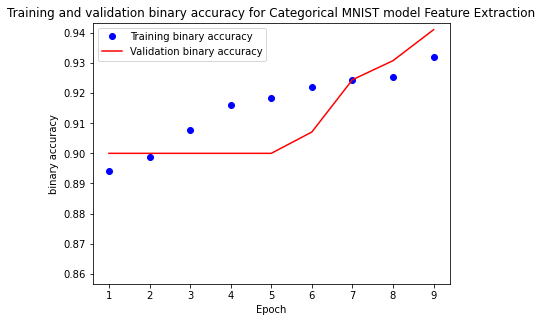

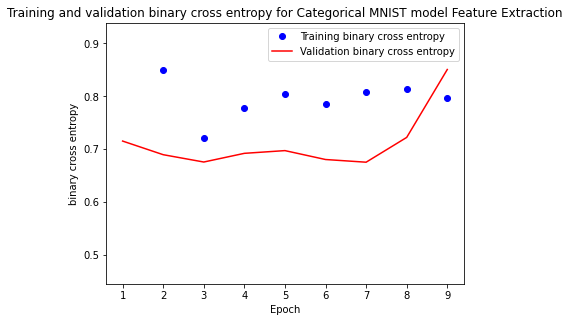

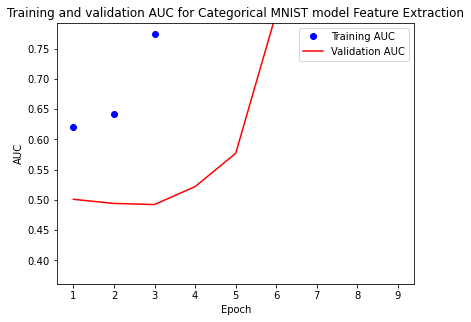

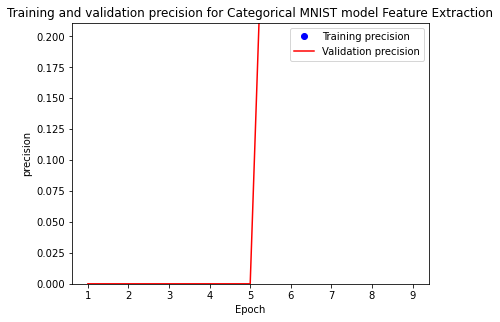

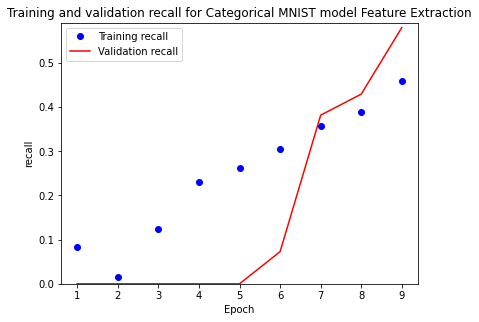

Epoch 1/50
100/100 [==============================] - 39s 216ms/step - loss: 1.0630 - binary_accuracy: 0.8929 - binary_crossentropy: 0.8749 - auc: 0.9532 - precision: 0.7546 - recall: 0.5750 - val_loss: 0.7861 - val_binary_accuracy: 0.4814 - val_binary_crossentropy: 0.7861 - val_auc: 0.4954 - val_precision: 0.1000 - val_recall: 0.0047


C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


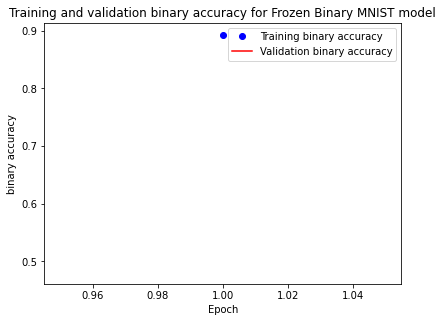

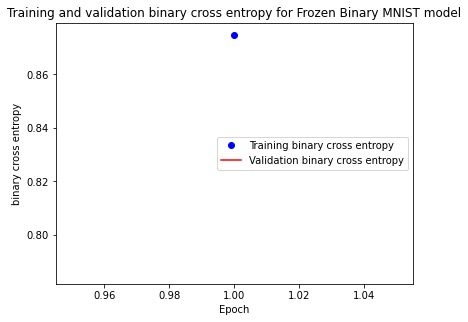

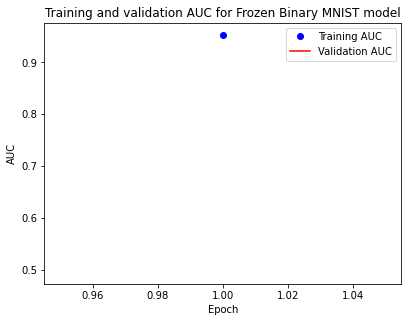

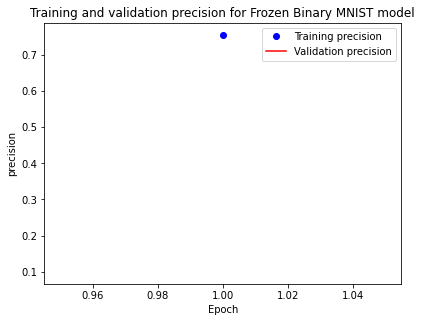

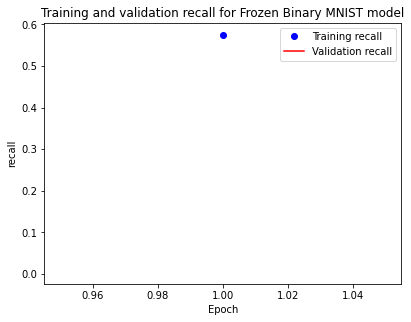

Epoch 1/24
  8/100 [=>............................] - ETA: 48s - loss: 0.8337 - binary_accuracy: 0.5090 - binary_crossentropy: 0.8107 - auc: 0.5349 - precision: 0.5128 - recall: 0.1814

KeyboardInterrupt: 

In [19]:
if compileMNISTEfficientNet:
    # MNIST data pipeline and EfficientNet base implementation
    efficientNetMinInputShape = (32, 32, 1) # MNISTInputShape is (28, 28)
    untrainedEfficientNetB1Base = buildEfficientNetBase(
        inputShape=efficientNetMinInputShape, 
        weights=None)
    untrainedEfficientNetB1Base.trainable = True
    
    efficientNetMNISTBaseOutputShape = untrainedEfficientNetB1Base.output_shape[1:]
    efficientNetMNISTBaseFlatOutputSize = np.product(efficientNetMNISTBaseOutputShape)
    
    # Import MNIST data and partitioning a validation set
    (MNISTValAndTrainImages, MNISTValAndTrainLabels), (MNISTTestImages, MNISTTestLabels) = mnist.load_data()
    
    MNISTTestImages = MNISTTestImages.astype('float32') / 255
    MNISTValAndTrainImages = MNISTValAndTrainImages.astype('float32') / 255
    
    MNISTValImages, MNISTTrainImages = MNISTValAndTrainImages[:len(MNISTTestImages)], MNISTValAndTrainImages[len(MNISTTestImages):]
    MNISTValLabels, MNISTTrainLabels = MNISTValAndTrainLabels[:len(MNISTTestImages)], MNISTValAndTrainLabels[len(MNISTTestImages):]
    
    # Transform MNIST samples to conform to minimum input size by padding with 4 background pixels on each spatial axis (2 before and after)
    MNISTTestImages = np.pad(
        MNISTTestImages, 
        pad_width=((0,0), (2,2), (2,2)), 
        constant_values=(0., 0.))
    MNISTValImages = np.pad(
        MNISTValImages, 
        pad_width=((0, 0), (2, 2), (2,2)), 
        constant_values=(0., 0.))
    MNISTTrainImages = np.pad(
        MNISTTrainImages, 
        pad_width=((0, 0), (2, 2), (2,2)), 
        constant_values=(0., 0.))
    
    MNISTTestLabels = keras.utils.to_categorical(MNISTTestLabels)
    MNISTValLabels = keras.utils.to_categorical(MNISTValLabels)
    MNISTTrainLabels = keras.utils.to_categorical(MNISTTrainLabels)
    
    # Model implementations
    #if 'MNISTEfficientNetB1CategoricalSavedModel' in filesInCwd:
    #    MNISTEfficientNetB1Categorical = models.load_model('MNISTEfficientNetB1CategoricalSavedModel')
    #else:
        # Build classifier for categorical (10-class) MNIST training
    efficientNetB1MNISTCategoricalClassifier = models.Sequential(name='efficientNetB1MNISTCategoricalClassifier')
    efficientNetB1MNISTCategoricalClassifier.add(
        layers.Dense(1024, 
                     activation='relu', 
                     input_dim=efficientNetMNISTBaseFlatOutputSize))

    efficientNetB1MNISTCategoricalClassifier.add(layers.BatchNormalization())
    efficientNetB1MNISTCategoricalClassifier.add(layers.Dense(256, activation='relu')) 
    efficientNetB1MNISTCategoricalClassifier.add(layers.Dropout(0.5))
    efficientNetB1MNISTCategoricalClassifier.add(layers.Dense(10, activation='softmax'))

    keras.utils.plot_model(efficientNetB1MNISTCategoricalClassifier,
                           to_file='efficientNetB1MNISTCategoricalClassifier.jpg',
                           show_shapes=True)

    # Compile and train EfficientNet model with categorical classifier on MNIST
    MNISTEfficientNetB1Categorical = models.Sequential(name='MNISTEfficientNetB1Categorical')
    MNISTEfficientNetB1Categorical.add(untrainedEfficientNetB1Base)
    MNISTEfficientNetB1Categorical.add(layers.Flatten())
    MNISTEfficientNetB1Categorical.add(efficientNetB1MNISTCategoricalClassifier)

    MNISTEfficientNetB1Categorical.compile(optimizer=tfa.optimizers.Yogi(),
                               loss='categorical_crossentropy',
                               metrics=metrics) # Metrics can be removed if desired

    gTTS(text="Starting training of MNIST EfficientNet Categorical").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    
    """
    finetunedModelHistory = finetunedModel.fit(
            efficientNetColorGenerators['train'],
            epochs=6,
            batch_size=globalBatchSize,
            validation_data=efficientNetColorGenerators['val'],
            callbacks=callbacks)
    """
    
    MNISTEfficientNetB1CategoricalHistory = trainOrResumeTrainingMNIST(
        MNISTEfficientNetB1Categorical,
        MNISTTrainImages, 
        labels=MNISTTrainLabels,
        validationData = (MNISTValImages, MNISTValLabels),
        epochs=9, #11
        stepsPerEpoch=100
    )
    
    metricsKeysNames = zipMetricsKeysWithNames(MNISTEfficientNetB1CategoricalHistory.history.keys(), 
                                               metricNames)
    plotTrainingHistories(MNISTEfficientNetB1CategoricalHistory, 
                          metricsKeysNames, 
                          'Categorical MNIST model Feature Extraction')
    plt.show()
    #"""
    # Pop the classifier off the model and rename the model. Freeze the base.
    MNISTEfficientNetB1Categorical.pop() # Removes the categorical classifier
    trainedEfficientNetB1Base = MNISTEfficientNetB1Categorical
    # Freeze layers. Don't freeze full model, since we're adding to it.
    for layer in trainedEfficientNetB1Base.layers:
        layer.trainable = False
    #"""
    """if 'MNISTBinaryFrozenBaseSavedModel' in filesInCwd:
        MNISTEfficientNetB1Binary = models.load_model('MNISTBinaryFrozenBaseSavedModel')
    else:"""
    #"""
    # Build binary MNIST model
    MNISTEfficientNetB1Binary = models.Sequential(name='MNISTEfficientNetB1Binary')

    # Block for downsampling from (204, 204, 3) to (32, 32, 1)
    MNISTDownsamplingBlock = models.Sequential(name='MNISTDownsamplingBlock')
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 
                                             5, 
                                             padding='valid', 
                                             activation = 'relu', 
                                             input_shape=(*imageResolution, 1))) # Output shape = (200, 200)
    
    MNISTDownsamplingBlock.add(layers.MaxPool2D(pool_size=(2, 2), padding='same')) # Output shape = (100, 100)
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (96, 96)
    MNISTDownsamplingBlock.add(layers.BatchNormalization()) #
    MNISTDownsamplingBlock.add(layers.MaxPool2D(pool_size=(2, 2), 
                                                padding='same', 
                                                input_shape=(*imageResolution, 1))) # Output shape = (48, 48)
    
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (44, 44)
    MNISTDownsamplingBlock.add(layers.BatchNormalization())
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (40, 40)
    MNISTDownsamplingBlock.add(layers.BatchNormalization()) #
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 5, padding='valid', activation = 'relu')) # Output shape = (36, 36)
    MNISTDownsamplingBlock.add(layers.BatchNormalization()) #
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 3, padding='valid', activation = 'relu')) # Output shape = (34, 34)
    MNISTDownsamplingBlock.add(layers.BatchNormalization()) #
    MNISTDownsamplingBlock.add(layers.Conv2D(1, 3, padding='valid', activation = 'relu')) # Output shape = (32, 32)
    MNISTDownsamplingBlock.add(layers.BatchNormalization())
    
    keras.utils.plot_model(MNISTDownsamplingBlock,
                   to_file='MNISTDownsamplingBlock.jpg',
                   show_shapes=True)

    # Add downsampling block and previous model to new model. Build and add new binary classifier.
    MNISTEfficientNetB1Binary.add(MNISTDownsamplingBlock)
    MNISTEfficientNetB1Binary.add(trainedEfficientNetB1Base)

    # Build classifier for binary MNIST model (for our dataset)
    efficientNetB1MNISTBinaryClassifier = models.Sequential(name='efficientNetB1MNISTBinaryClassifier')
    efficientNetB1MNISTBinaryClassifier.add(layers.Dense(1024, 
                                                         activation='relu', 
                                                         input_dim=efficientNetMNISTBaseFlatOutputSize))
    
    efficientNetB1MNISTBinaryClassifier.add(layers.BatchNormalization())
    efficientNetB1MNISTBinaryClassifier.add(layers.Dense(256, activation='relu')) 
    efficientNetB1MNISTBinaryClassifier.add(layers.Dropout(0.5))
    efficientNetB1MNISTBinaryClassifier.add(layers.Dense(1, activation='sigmoid'))
    keras.utils.plot_model(efficientNetB1MNISTBinaryClassifier,
                           to_file='efficientNetB1MNISTBinaryClassifier.jpg',
                           show_shapes=True)

    # Combine base and classifier
    MNISTEfficientNetB1Binary.add(efficientNetB1MNISTBinaryClassifier)
    MNISTEfficientNetB1Binary.compile(optimizer=tfa.optimizers.Yogi(),
                                       loss='binary_crossentropy',
                                       metrics=metrics)

    gTTS(text="Starting training of MNIST EfficientNet Binary Frozen Base").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    MNISTEfficientNetB1BinaryClassifierHistory = trainOrResumeTrainingMNIST(
        MNISTEfficientNetB1Binary,
        efficientNetGrayscaleGenerators['train'],
        modelName='MNISTBinaryFrozenBase',
        validationData=efficientNetGrayscaleGenerators['val'],
        epochs=50) # globalFinetuningEpochs) # 
    
    metricsKeysNames = zipMetricsKeysWithNames(MNISTEfficientNetB1BinaryClassifierHistory.history.keys(), 
                                               metricNames)
    plotTrainingHistories(MNISTEfficientNetB1BinaryClassifierHistory, 
                          metricsKeysNames, 
                          'Frozen Binary MNIST model')
    plt.show()
    
    
    # Finetuning with a few unfrozen top layers. Note that this is the same model object but this version is named 'MNISTBinaryHotBase' for checkpoints rather than
    # 'MNISTBinaryFrozenBase'
    #trainedEfficientNetB1Base.trainable = True
    for layer in trainedEfficientNetB1Base.layers:
        if layer.name not in layersToUnfreeze:
            layer.trainable = False
    
    MNISTEfficientNetB1 = models.Sequential(name='MNISTEfficientNetB1')
    MNISTEfficientNetB1.add(MNISTEfficientNetB1Binary.get_layer(name='MNISTDownsamplingBlock'))
    MNISTEfficientNetB1.add(trainedEfficientNetB1Base)
    MNISTEfficientNetB1.add(MNISTEfficientNetB1Binary.get_layer(name='efficientNetB1MNISTBinaryClassifier'))
    MNISTEfficientNetB1.compile(optimizer=tfa.optimizers.Yogi(learning_rate=globalFinetuningLearningRate),
                                loss='binary_crossentropy',
                                metrics=metrics)
    
    gTTS(text="Starting training of MNIST EfficientNet Binary Hot Base").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    MNISTEfficientNetB1History = trainOrResumeTrainingMNIST(MNISTEfficientNetB1,
                                                            efficientNetGrayscaleGenerators['train'],
                                                            modelName = MNISTEfficientNetModelName,
                                                            validationData=efficientNetGrayscaleGenerators['val'],
                                                            epochs=24) # globalFinetuningEpochs)
    
    print("Now testing MNIST model:")
    MNISTEfficientNetTestScores = MNISTEfficientNetB1Binary.evaluate(
        efficientNetGrayscaleGenerators['test'], 
        batch_size=globalBatchSize, 
        return_dict=True,
        callbacks=[tf.keras.callbacks.CSVLogger('MNISTEfficientNetTestLog.csv')])
    
    #MNISTEfficientNetB1.save(MNISTEfficientNetModelName)
    keras.utils.plot_model(MNISTEfficientNetB1,
                           to_file='MNISTEfficientNetB1.jpg',
                           show_shapes=True)
    
    metricsKeysNames = zipMetricsKeysWithNames(MNISTEfficientNetB1History.history.keys(), 
                                               metricNames)
    plotTrainingHistories(MNISTEfficientNetB1History, 
                          metricsKeysNames, 
                          'Hot binary MNIST model')
    plt.show()
# Try with: step_size 100, epochs = 9, 

# Test scores for epochs = 9, frozen finet. epochs = 50, hot finetuning epochs = 24: acc 0.9, XE 0.2965, AUC 0.9038, Prec 0.8496, Recall 0.9721

### 2.2 Plotting the model statistics and performing tests

#### 2.2.1 History plotting functions

#### 2.2.2 History plots for baseline CNN

In [ ]:
if compileBaselineCNN:
    metricsKeysNames = zipMetricsKeysWithNames(baselineCNNHistory.history.keys(), metricNames)
    plotTrainingHistories(baselineCNNHistory, metricsKeysNames, 'Baseline CNN')
    plt.show()

#### 2.2.3 History plots for EfficientNet feature extractor

In [ ]:
if compileEfficientNetFE:
    metricsKeysNames = zipMetricsKeysWithNames(
        efficientNetB1FEClassifierHistory.history.keys(), 
        metricNames)
    plotTrainingHistories(
        efficientNetB1FEClassifierHistory, 
        metricsKeysNames, 
        'EfficientNet Feature Extraction')
    plt.show()

#### 2.2.4 History plots for finetuned EfficientNet

In [ ]:
if compileFinetunedEfficientNet:
    metricsKeysNames = zipMetricsKeysWithNames(
        finetunedEfficientNetB1History.history.keys(), 
        metricNames)
    plotTrainingHistories(
        finetunedEfficientNetB1History, 
        metricsKeysNames, 
        'Finetuned EfficientNet')
    plt.show()

#### 2.2.5 History plots for MNIST-EfficientNet finetuning

In [ ]:
if compileMNISTEfficientNet:
    metricsKeysNames = zipMetricsKeysWithNames(MNISTEfficientNetB1History.history.keys(), metricNames)
    plotTrainingHistories(MNISTEfficientNetB1History, metricsKeysNames, 'MNIST EfficientNet')
    plt.show()

#### 2.2.6 Function for generating aggregate multiplots from saved plot images

In [ ]:
##
mainModelNames = ['BaselineCnn', 'EfficientNetFeatureExtraction']
finetuningModelNames = ['FinetunedEfficientNet', 'MNISTEfficientNet']

binaryAccuracyCrossEntropyMetricNames = ['BinaryAccuracy', 'BinaryCrossEntropy']
precisionRecallMetricNames = ['Precision', 'Recall']

numEpochsFirstPhase = [40, 40]
numEpochsSecondPhase = [6, 4]
numEpochsSecondPhaseFinetuning = [20, 24]

generateMultiplot = True
##

def plotAggregateStats(modelNames, metricNames, numEpochs):
    numModels = len(modelNames)
    numMetrics = len(metricNames)
    
    fig = plt.figure(figsize=(6.4*(numMetrics), 4.8*(numModels))) # Multiples of default size
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0.025, bottom=0.025)

    subplotIndex = 1
    epochIndex = 0
    for model in modelNames:
        epochs = numEpochs[epochIndex]
        for metric in metricNames:
            fig.add_subplot(numModels, 
                            numMetrics, 
                            subplotIndex, 
                            frame_on=False, 
                            aspect='equal')
            graph = plt.imread(f'{model}{metric}{epochs}Epochs.jpeg')
            plt.axis('off')
            plt.imshow(graph, aspect='equal')
            subplotIndex += 1
        epochIndex += 1
    #plt.suptitle('Training statistics for baseline models', size=30., y=0.92)
    plt.savefig(
        f'AggregateTrainStats{numModels}Models{numMetrics}MetricsIncl{modelNames[0]}{metricNames[0]}{numEpochs[0]}Epochs.jpeg')
    
if generateMultiplot:
    plotAggregateStats(mainModelNames, 
                       binaryAccuracyCrossEntropyMetricNames, 
                       numEpochsSecondPhase)
    plotAggregateStats(mainModelNames, 
                       precisionRecallMetricNames, 
                       numEpochsSecondPhase)
    plotAggregateStats(finetuningModelNames, 
                       binaryAccuracyCrossEntropyMetricNames, 
                       numEpochsSecondPhaseFinetuning)
    plotAggregateStats(finetuningModelNames, 
                       precisionRecallMetricNames, 
                       numEpochsSecondPhaseFinetuning)

#### 2.2.7 Testing the baseline models

In [ ]:
if doSerialTests:
    gTTS(text="Now testing the models.").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")

    if compileBaselineCNN:
        print('Baseline CNN:')
        baselineCNNTestScores = baselineCNN.evaluate(
            baselineCNNGenerators['test'], 
            batch_size=globalBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('BaselineCNNTestLog.csv')])
    
    if compileEfficientNetFE:
        print('EfficientNet feature extraction:')
        efficientNetFETestScores = efficientNetB1FEClassifier.evaluate(
            efficientNetColorGenerators['test'], 
            batch_size=globalBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('efficientNetFETestLog.csv')])
    
    if compileFinetunedEfficientNet:
        print('Finetuned EfficientNet:')
        finetunedEfficientNetTestScores = finetunedEfficientNetB1.evaluate(
            efficientNetColorGenerators['test'], 
            batch_size=globalBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('finetunedEfficientNetTestLog.csv')])
    
    if compileMNISTEfficientNet:
        print('MNIST EfficientNet:')
        MNISTEfficientNetTestScores = MNISTEfficientNetB1Binary.evaluate(
            efficientNetGrayscaleGenerators['test'], 
            batch_size=globalBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger('MNISTEfficientNetTestLog.csv')])

## 3 Advanced experiments on the pre-trained EfficientNets

### 3.1 Performance relation to pre-trained model depth
The same EfficientNet setup is tested while removing different numbers of layers from the top of the pre-trained model.

In [ ]:
if doLayerExperiment:
    gTTS(text="Commencing block-wise output experiment.").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    
    intermediateLayerBatchSize = 4 # Needed to avoid OOM
    efficientNetB1Base = buildEfficientNetBase()
    
    for (outputLayer, epochs) in zip(blockwiseOutputLayers, [40, 40, 40, 40, 40, 40]): #blockwiseEpochs): # Set in Cockpit
        # We need to reinstate generators per loop to avoid dataflow errors
        efficientNetColorGenerators = produceDataGenerators(colorMode='rgb', batchSize=intermediateLayerBatchSize)
        
        # I.e. the model produced by using the output of the given output block
        blockwiseBase = tf.keras.Model(
            inputs=efficientNetB1Base.input, 
            outputs=efficientNetB1Base.get_layer(outputLayer).output)
        blockwiseBase.trainable = False

        blockwiseBaseOutputShape = blockwiseBase.output_shape[1:]
        blockwiseBaseFlatOutputSize = np.product(blockwiseBaseOutputShape)

        colorFeatureSets = extractFeatureSets(blockwiseBase, efficientNetColorGenerators, batchSize=intermediateLayerBatchSize)
        FEClassifier = models.Sequential(name=f'efficientNetB1{outputLayer}FEClassifier')
        
        FEClassifier.add(layers.Dense(128, activation='relu', input_dim=blockwiseBaseFlatOutputSize)) # Needed to avoid OOM
        FEClassifier.add(layers.Dropout(0.5))
        FEClassifier.add(layers.Dense(1, activation='sigmoid'))

        FEClassifier.compile(optimizer=tfa.optimizers.Yogi(),
                             loss='binary_crossentropy',
                             metrics=metrics)
        FEClassifierHistory = FEClassifier.fit(colorFeatureSets['train'][0], 
                                               colorFeatureSets['train'][1],
                                               epochs=epochs, # 40, 4, 10, globalEpochs
                                               batch_size=intermediateLayerBatchSize,
                                               validation_data=(colorFeatureSets['val'][0], colorFeatureSets['val'][1]),
                                               callbacks=callbacks)
        
        metricsKeysNames = zipMetricsKeysWithNames(FEClassifierHistory.history.keys(), 
                                                   metricNames)
        plotTrainingHistories(FEClassifierHistory, 
                              metricsKeysNames, 
                              f'{outputLayer}-model Feature Extraction')
        plt.show()

        print(f'Testing {outputLayer}-model:')
        FEClassifierTestScores = FEClassifier.evaluate(
            colorFeatureSets['test'][0], 
            colorFeatureSets['test'][1], 
            batch_size=intermediateLayerBatchSize, 
            return_dict=True,
            callbacks=[tf.keras.callbacks.CSVLogger(
                f'{outputLayer}EfficientNetFETestLog.csv')])
        # Do write about the decreased input layer and batch size!

### 3.2 Performance as a function of dataset size
The same feature extraction model is trained for successive tenths of the full dataset.

In [ ]:
if doDatasetSizeExperiment:
    gTTS(text="Commencing sample size experiment.").save('TTSTick.mp3')
    os.system("cd bachelor & .\\cmdmp3 TTSTick.mp3")
    
    efficientNetB1Base = buildEfficientNetBase()
    batchSize = 4 # We will need a much smaller batchSize to play nice with the truncation of the dataset by batch size
    
    for (tenths, epochs) in zip(range(1, 10), [40, 40, 40, 40, 40, 40, 40, 40, 40]): # sampleSizeWiseEpochs # Set in Cockpit        
        # We need to reinstate generators for each loop to avoid dataflow errors
        efficientNetColorGenerators = produceDataGenerators(colorMode='rgb', batchSize=batchSize)
        numTrainSamplesToUse = (efficientNetColorGenerators['train'].n // 10) * tenths
        numTestSamplesToUse = (efficientNetColorGenerators['test'].n // 10) * tenths
        numValSamplesToUse = (efficientNetColorGenerators['val'].n // 10) * tenths
        
        colorFeatureSets = extractFeatureSets(
            efficientNetB1Base, 
            efficientNetColorGenerators, 
            numSamplesList=[numTrainSamplesToUse, numTestSamplesToUse, numValSamplesToUse],
            batchSize=batchSize)

        FEClassifier, FEClassifierHistory, FETestScores = buildFeatureExtractionClassifier( # TestScores currently unused
            featureSets=colorFeatureSets,
            baseModel=efficientNetB1Base, 
            modelName=f'efficientNetB1{numTrainSamplesToUse}SamplesFEClassifier',
            epochs=epochs,
            batchSize=batchSize)
        
        metricsKeysNames = zipMetricsKeysWithNames(FEClassifierHistory.history.keys(), metricNames)
        plotTrainingHistories(
            FEClassifierHistory, 
            metricsKeysNames, 
            f'{numTrainSamplesToUse} training samples {epochs} epochs model Feature Extraction')
        plt.show()

## 4 Optimization

### 4.1 Basic augmentations gridsearch

In [ ]:
def chooseBasicAugmentations(augmentationsIn:dict, # Dictionary of augmentation names and their argument type
                             numRange=[1, 2, 3], 
                             maxFloatIntensity=0.4, 
                             maxIntIntensity=72):
    """
    Initiate a set of neutral (off) augmentations, then random draw 'num' augmentations and random draw their 
    intensities below the max level. Return the updated set of augmentations. Note that a setup is used where e.g. 
    width/height shift are considered a single transformation, and thus should be processed as that, so that 
    the chance of triggering both of these transformations is not twice the chance of the other augmentations.
    """
    num = np.random.choice(numRange)
    augmentationIndices = np.random.choice(len(augmentationsIn), size=num)
    augKeyList = np.array(list(augmentationsIn.keys()))
    augStrs = augKeyList[augmentationIndices] # strs?
    
    augmentationsOut = {
        'rotation_range':0,
        'width_shift_range':0.0,
        'height_shift_range':0.0,
        'shear_range':0.0,
        'zoom_range':0.0,
        'horizontal_flip':False,
        'vertical_flip':False
    }        
    
    M_float = np.random.uniform(high=maxFloatIntensity)
    M_int = int(M_float*180)
    
    for augStr in augStrs:
        typeOfAug = type(augmentationsIn[augStr])
        if typeOfAug == float:
            if augStr == 'width_height_shift_range':
                augmentationsOut['width_shift_range'] = M_float
                augmentationsOut['height_shift_range'] = M_float
            else:
                augmentationsOut[augStr] = M_float
        elif typeOfAug == int:
            augmentationsOut[augStr] = M_int # Pending any changes, this only concerns rotation_range. Current default is 20% of 180 deg, i.e. 36 degrees.
        elif typeOfAug == tuple:
            augmentationsOut[augStr] = (0., M_float) 
        elif typeOfAug == bool:
            if augStr == 'horizontal_vertical_flip': # Currently in fact the only outcome
                augmentationsOut['horizontal_flip'] = True
                augmentationsOut['vertical_flip'] = True
            else:
                augmentationsOut[augStr] = True
    return augmentationsOut
        
def basicAugmentationsGridSearch(augmentationsIn, numAttempts, numRange = [1, 2, 3], epochs=8):
    augmentationsTestScoresDict = {}
    for _ in range(numAttempts):  
        modelBase = buildEfficientNetBase()
        
        augmentationsSample = chooseBasicAugmentations(augmentationsIn, numRange=numRange)
        dataGenerators = produceDataGenerators(augmentations=augmentationsSample)
        classifier, classifierHistory, testScores = extractFeaturesAndBuildModel(
            modelBase=efficientNetB1Base,
            dataGenerators=dataGenerators,
            modelName = 'randomAugmentationsFEModel',
            epochs=epochs
        )
        
        metricsKeysNames = zipMetricsKeysWithNames(classifierHistory.history.keys(), 
                                               metricNames)
        
        # Format the names of augmentations for plotting
        augmentationDescriptionString = ""
        for key in augmentationsSample.keys():
            if augmentationsSample[key] > 0: # By the power of type conversion, this works.
                if type(augmentationsSample[key]) == float:
                    formattedValue = "{:.4f}".format(augmentationsSample[key])
                else:
                    formattedValue = str(augmentationsSample[key])
                augmentationDescriptionString += "\n" + key + " " + formattedValue
            
        if augmentationDescriptionString not in augmentationsTestScoresDict.keys():
            augmentationsTestScoresDict[augmentationDescriptionString] = testScores
        
        testScores['description'] = augmentationDescriptionString
        np.save('basicAugmentationGridSearchTestScores.npy', testScores) # Appends to file behavior
        
        # Ugly manual garbage collection to avoid OOM
        del modelBase
        del dataGenerators
        del classifier
        del classifierHistory
        del testScores
        gc.collect()
        #
        
        """
        plotTrainingHistories(classifierHistory, 
                              metricsKeysNames, 
                              f'random augmented model')
        
        plt.text(0., 
                 0.5, 
                 f'{augmentationDescriptionString}', 
                 horizontalalignment='center', 
                 verticalalignment='center', 
                 transform=ax.transAxes, 
                 bbox=dict(facecolor='black'))

        plt.show()
        """
    return augmentationsTestScoresDict

augmentationsIn = {
    'rotation_range':0,
    'width_height_shift_range':0.0,
    'shear_range':0.0,
    'zoom_range':0.0,
    'horizontal_vertical_flip':False
} 

if doBasicAugmentationsTest:
    augmentationsTestScoresDict = basicAugmentationsGridSearch(augmentationsIn, 80)

### 4.2 Label smoothing search

In [ ]:
doLabelSmoothingSearch = False
if doLabelSmoothingSearch:
    for smoothingIntensity in [0.1, 0.2]: # [0.1, 0.2, 0.3, 0.5, 0.7]
        dataGenerators = produceDataGenerators()
        modelBase = buildEfficientNetBase()

        classifier, classifierHistory, testScores = extractFeaturesAndBuildModel(
            modelBase=modelBase,
            dataGenerators=dataGenerators,
            modelName='labelSmoothedFEModel',
            epochs=20,
            labelSmoothing=smoothingIntensity
        )
        metricsKeysNames = zipMetricsKeysWithNames(classifierHistory.history.keys(), 
                                                   metricNames)
        plotTrainingHistories(classifierHistory, 
                              metricsKeysNames, 
                              f'{smoothingIntensity} smoothing intensity model Feature Extraction')
        plt.show()
        del modelBase
        del dataGenerators
        del classifier
        del classifierHistory
        del testScores
        gc.collect()

### 4.4 Advanced augmentations gridsearch

In [ ]:
# Create image-wise augmentation functions here. Then implement them as lambda layers. At the end, either instantiate one model per augmentation or an iterator function
# In the below, we simply apply augmentations live. We don't actually "inflate" the dataset. So we can try to train for longer, knowing that we will see fewer repeat samples per epoch. But we do not keep count of the "size" of the inflated dataset.
""""""
# Auxiliary functions
draw = np.random.uniform

#
def drawSquareInBatch(batch, maxSizeRatio=0.2): ### IMG version
    # Could be numpy optimised, but I don't have the time.
    centerX = int(round(np.random.choice(batch.shape[0])))
    centerY = int(round(np.random.choice(batch.shape[1])))
    sizeFactor = draw(high=maxSizeRatio)
    squareStart = [centerX - int(round((sizeFactor*batch.shape[0]))), 
                         centerY - int(round(sizeFactor*batch.shape[1]))] # I.e. top left 
    squareEnd = [centerX + int(round((sizeFactor*batch.shape[0]))), 
                         centerY + int(round(sizeFactor*batch.shape[1]))] # I.e. top
    if squareStart[0] < 0:
        squareStart[0] = 0
    if squareStart[1] < 0:
        squareStart[1] = 0
        
    if squareEnd[0] > batch.shape[0]:
        squareEnd[0] = batch.shape[0]
    if squareEnd[1] > batch.shape[1]:
        squareEnd[1] = batch.shape[1]
    return [squareStart, squareEnd]

def cutOut(batch, activationChance=0.05, maxSizeRatio=0.2, neutralValue=255/2.): # neutralValue is the "background color". In the paper, the boxes are made of the mean pixel value in that the input distribition is converted to a distribution around 0. It is currently chosen as 255/2 i.e. channel-wise grey.
    # I'm following an intuition in the paper that less classes require less cutOut
    # Note that EfficientNet performs 1 / 255 rescaling as part of a rescaling layer. This makes the "mean input value" essentially the color    
    
    # Note that out-of-bounds cutOut boxes are allowed as per the paper
    # Input shape: batch, x, y, channel
    if draw() < activationChance:
        square = drawSquareInBatch(batch, maxSizeRatio=maxSizeRatio)
        batch[square[0][0]:square[1][0], square[0][1]:square[1][1]] = neutralValue # Does this work?       
    return batch

def patchShuffle(batch, activationChance=0.05, M = 0.4): # smaller activation chance is recommended. #### IMG-WISE
    # Assumes square input
    N = round(M*20)
    numPatchDelimiters = (batch.shape[0]) // N
    patchDelimiters = np.array([N*i for i in range(numPatchDelimiters)])
    for delimiterX in patchDelimiters:
        for delimiterY in patchDelimiters:
            #for channel in batch: # WRITE A NOTE ABOUT THIS NIGHTMARE!!
            np.random.shuffle(batch[delimiterX:delimiterX + N, delimiterY:delimiterY + N])
    return batch

In [ ]:
def prepareImgWiseCutOut(activationChance, maxSizeRatio):
    return lambda img: cutOut(img, activationChance=activationChance, maxSizeRatio=maxSizeRatio)
def prepareImgWisePatchShuffle(activationChance, M):
    return lambda img: patchShuffle(img, activationChance=activationChance, M=M)


def performAdvancedAugmentationGridsearch(augmentationFunction,
                                          activationChances,
                                          Ms):
    testScores = []
    for i in range(len(activationChances)):
        """
        if i == 1:
            return pd.DataFrame([[augmentationFunction for _ in range(len(activationChances))], activationChances, Ms, testScores], 
                                columns=['Augmentation Function',
                                         'Activation chance',
                                         'M', 
                                         'Test score'])
        """
        for j in range(len(Ms)): #range(len(Ms)):
            if augmentationFunction == 'cutOut':
                imgWiseCutOut = prepareImgWiseCutOut(activationChances[i], Ms[j])
                dataGenerators = produceDataGenerators(preprocessingFunction=imgWiseCutOut)
            elif augmentationFunction == 'patchShuffle':
                imgWisePatchShuffle = prepareImgWisePatchShuffle(activationChances[i], Ms[j])
                dataGenerators = produceDataGenerators(preprocessingFunction=imgWisePatchShuffle)
            else:
                raise("Unknown augmentation function.")
            modelBase = buildEfficientNetBase()
            augmentedClassifier, augmentedClassifierHistory, augmentedTestScores = extractFeaturesAndBuildModel(
                modelBase=modelBase,
                dataGenerators=dataGenerators,
                modelName=f'AdvancedAugModel',
                epochs=8 # 4 We test with more epochs to see if the model seems to have space for longer training.
            )
            testScores.append(augmentedTestScores)
            print(f"\n\nFor {augmentationFunction}, for activationChance {activationChances[i]} and M {Ms[j]}, test scores were\n{augmentedTestScores}\n\n")
            del modelBase
            del dataGenerators
            del augmentedClassifier
            del augmentedClassifierHistory
            del augmentedTestScores
            gc.collect()
    gridsearchResultDataframe = pd.DataFrame({'Augmentation Function':[augmentationFunction for _ in range(len(activationChances))],
                                             'Activation Chance':activationChances,
                                             'M':Ms,
                                             'Test XE':testScores['loss']})
        #[[augmentationFunction for _ in range(len(activationChances))], activationChances, Ms, testScores], 
        #columns=['Augmentation Function',
        #         'Activation chance',
        #         'M', 
        #         'Test score'])
    gridsearchResultDataframe.to_csv('AdvAugGrid.zip', index=False)
    return gridsearchResultDataframe

gridsearchResultDataframe = performAdvancedAugmentationGridsearch('patchShuffle',
                                                                  activationChances=[0.1, 0.2, 0.3, 0.4],
                                                                  Ms=[0.1, 0.2, 0.3, 0.4])
print(gridsearchResultDataframe)

In [ ]:
def createPairwiseAugmentedDataset(generatorFactory,
                                   augmentation,
                                   batchesOfAugmentedSamples:int,
                                   intensity=0.2,
                                   batchSize=16):
    dataset = tf.data.Dataset.from_generator(lambda: generatorFactory.flow_from_directory(trainDir,
                                                                                             target_size=imageResolution,
                                                                                             batch_size=batchSize,
                                                                                             color_mode='rgb',
                                                                                             class_mode='binary'),
                                             output_types=(tf.float32, tf.float32))
    # The dataset inherits its batch_size from the flow_from_directory object, so don't create a batchwise iterator here.
    datasetOut = dataset
    ##
    shufflingDataset = dataset.batch(1).shuffle(batchSize, reshuffle_each_iteration=True)
    i = 0
    while i < batchesOfAugmentedSamples: #effectiveNumberOfBatches:
        iterator = shufflingDataset.as_numpy_iterator()
        shuffledSamplesA, shuffledLabelsA = iterator.next() #shufflingDataset.as_numpy_iterator().next() #shufflingDataset#.as_numpy_iterator().next()
        shuffledSamplesB, shuffledLabelsB = iterator.next() # shufflingDataset.as_numpy_iterator().next() #shufflingDataset.as_numpy_iterator().next()
        combinedSamples, combinedLabels = augmentation((shuffledSamplesA, shuffledLabelsA),
                                                      (shuffledSamplesB, shuffledLabelsB),
                                                      intensity=intensity)
        combinedDataset = tf.data.Dataset.from_tensor_slices((combinedSamples, combinedLabels))
        datasetOut = datasetOut.concatenate(combinedDataset)
        i += 1
        del iterator
        del combinedSamples
        del combinedLabels
        del shuffledSamplesA
        del shuffledSamplesB
        del shuffledLabelsA
        del shuffledLabelsB
        del combinedDataset
        gc.collect()
    numSamplesAdded = batchesOfAugmentedSamples*batchSize
    return datasetOut, numSamplesAdded

def samplePairing(samplesWithLabelsA:tuple, samplesWithLabelsB:tuple, intensity=None):
    return 0.5*samplesWithLabelsA[0] + 0.5*samplesWithLabelsB[0], samplesWithLabelsA[1]

def mixUp(samplesWithLabelsA:tuple, samplesWithLabelsB:tuple, intensity=0.25):
    # alphas in range [0.1, 0.4] were seen to work well on imageNet, but alpha was seen to be quite variable between datasets. Run a gridsearch for alpha if possible.
    alpha = intensity
    L = np.random.beta(alpha, alpha)
    outBatch = L*samplesWithLabelsA[0] + (1 - L)*samplesWithLabelsB[0]
    outLabels = L*samplesWithLabelsA[1] + (1 - L)*samplesWithLabelsA[1]
    return outBatch, outLabels

In [ ]:
#### TESTING THE BASELINE MODEL

#def testAugmentedCNN():
epochs = 200
batchSize = 4
basicAugs = {
            'rotation_range':0.146*180,
            'width_shift_range':0.0,
            'height_shift_range':0.0,
            'shear_range':0.146,
            'zoom_range':0.,
            'horizontal_flip':True,
            'vertical_flip':True
}
#labelSmoothing = 0.2
#advAugmentation = #
#M = 0.2
numBatches = 64
#alpha = 0.3
#activationChance = 0.4

#imgWiseCutOut = prepareImgWiseCutOut(activationChances, M)
imgWisePatchShuffle = prepareImgWisePatchShuffle(0.4, 0.2)
dataGeneratorFactory, dataGenerators = produceDataGenerators(augmentations=basicAugs, 
                                                             preprocessingFunction=imgWisePatchShuffle, 
                                                             produceFactory=True, 
                                                             batchSize=batchSize)
inputShape = (*imageResolution, 3)
#"""
augmentedDataset, numSamplesAdded = createPairwiseAugmentedDataset(
    dataGeneratorFactory, 
    mixUp, 
    numBatches, 
    intensity=0.2,
    batchSize=batchSize
)
#"""
dataGenerators['train'] = augmentedDataset

modelBase = buildEfficientNetBase(weights=None)
#modelBase.trainable = True
numSamplesList = [1292 + numSamplesAdded, None, None]
augmentedClassifier, augmentedClassifierHistory, augmentedTestScores = extractFeaturesAndBuildModel(
    modelBase=modelBase,
    dataGenerators=dataGenerators,
    modelName=f'PairwiseAdvancedAugModel',
    epochs=200,
    numSamplesList=numSamplesList,
    batchSize=batchSize)# 4 We test with more epochs to see if the model seems to have space for longer training.

#print(f"\n\nFor {numBatches} batches and M {M}, test scores were\n{augmentedTestScores}\n\n")
    
metricsKeysNames = zipMetricsKeysWithNames(augmentedClassifierHistory.history.keys(), metricNames)
plotTrainingHistories(
    augmentedClassifierHistory, 
    metricsKeysNames, 
    f'Heavily augmented untrained EfficientNet')
plt.show()
del modelBase
del dataGenerators
del dataGeneratorFactory
del augmentedDataset
del augmentedClassifier
del augmentedClassifierHistory
del augmentedTestScores
gc.collect()
"""
baselineCNN = models.Sequential(name='augmentedBaselineCNN')
baselineCNN.add(layers.Conv2D(32, 
                              (3, 3), 
                              activation='relu', 
                              input_shape=inputShape))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
baselineCNN.add(layers.MaxPooling2D((2,2)))
baselineCNN.add(layers.Flatten())
baselineCNN.add(layers.Dropout(0.5))
baselineCNN.add(layers.Dense(512, activation='relu'))
baselineCNN.add(layers.Dense(1, activation='sigmoid'))

baselineCNN.compile(optimizer=tfa.optimizers.Yogi(),
                    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2),
                    metrics=metrics)
baselineCNNHistory = baselineCNN.fit(dataGenerators['train'],
                                     epochs=epochs, # globalEpochs
                                     batch_size=batchSize,
                                     validation_data=dataGenerators['val'],
                                     callbacks=callbacks)
print("Now testing:")
baselineCNNTestScores = baselineCNN.evaluate(
        dataGenerators['test'], 
        batch_size=batchSize, 
        return_dict=True,
        callbacks=[tf.keras.callbacks.CSVLogger('BaselineCNNTestLog.csv')])
"""



# If this keeps acting super weird, remember that it was trained on grayscale!

In [ ]:
def performPairwiseAugmentationGridsearch(augmentation, numBatchesList:list, Ms:list, batchSize=globalBatchSize, augmentationIsMixUp=False):
    testXEs = []
    testAccs = []
    for numBatches in numBatchesList:
        for i, M in enumerate(Ms):
            if i == 1 and not(augmentationIsMixUp):
                break
            dataGeneratorFactory, dataGenerators = produceDataGenerators(produceFactory=True, batchSize=batchSize)
            augmentedDataset, numSamplesAdded = createPairwiseAugmentedDataset(
                dataGeneratorFactory, 
                augmentation, 
                numBatches, 
                intensity=M,
                batchSize=batchSize
            )
            dataGenerators['train'] = augmentedDataset
            
            modelBase = buildEfficientNetBase()
            numSamplesList = [1292 + numSamplesAdded, None, None]
            augmentedClassifier, augmentedClassifierHistory, augmentedTestScores = extractFeaturesAndBuildModel(
                modelBase=modelBase,
                dataGenerators=dataGenerators,
                modelName=f'PairwiseAdvancedAugModel',
                epochs=8,
                numSamplesList=numSamplesList,
                batchSize=batchSize# 4 We test with more epochs to see if the model seems to have space for longer training.
            )
            testXEs.append(augmentedTestScores['loss'])
            testAccs.append(augmentedTestScores['binary_accuracy'])
            print(f"\n\nFor {numBatches} batches and M {M}, test scores were\n{augmentedTestScores}\n\n")
            del modelBase
            del dataGenerators
            del dataGeneratorFactory
            del augmentedDataset
            del augmentedClassifier
            del augmentedClassifierHistory
            del augmentedTestScores
            gc.collect()
    gridsearchResultDataframe = pd.DataFrame(
        [[augmentation for _ in range(len(numBatchesList))], numBatchesList, Ms, testXEs, testAccs])#, 
        #columns=['Augmentation Function',
        #         'Number of augmented batches',
        #         'M', 
        #         'Test XE',
        #         'Test Acc'])
    gridsearchResultDataframe.to_csv('AdvPairAugGrid.zip', index=False)
    return gridsearchResultDataframe

gridsearchResultDataframe = performPairwiseAugmentationGridsearch(mixUp,
                                                                  numBatchesList=[8, 16, 32, 64, 96],   #[2, 4, 8, 12, 16],
                                                                  Ms=[0.1, 0.2, 0.3, 0.5], 
                                                                  batchSize=4,
                                                                  augmentationIsMixUp=True) #
print(gridsearchResultDataframe)

### Everything below here is unfinished.

Gridsearch of best performing single setups. 

In [ ]:
def performFinalistGridsearch(basicAugs, 
                              labelSmoothings:list, 
                              advAug, 
                              pairwiseAug, 
                              numBatches, 
                              singleM, 
                              pairwiseM):
    setups = []
    testXEs = []
    testAccs = []
    for labelSmoothing in labelSmoothings:
        for useBasicAugs in [basicAugs, {
            'rotation_range':0.0,
            'width_shift_range':0.0,
            'height_shift_range':0.0,
            'shear_range':0.0,
            'zoom_range':0.,
            'horizontal_flip':False,
            'vertical_flip':False
        }]:
            for useAdvAug in [advAug, None]:
                for usePairwiseAug in [pairwiseAug, None]:
                    ### BasicAug, advAug, pairwiseAug
                    modelBase = buildEfficientNetBase()
                    if usePairwiseAug:
                        dataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator(
                            preprocessing_function = advAug,
                            rotation_range = basicAugs['rotation_range'], 
                            width_shift_range = basicAugs['width_shift_range'], 
                            height_shift_range = basicAugs['height_shift_range'],
                            shear_range = basicAugs['shear_range'], 
                            zoom_range = basicAugs['zoom_range'],
                            horizontal_flip = basicAugs['horizontal_flip'], 
                            vertical_flip = basicAugs['vertical_flip'])
                        augmentedDataset = createPairwiseAugmentedDataset(dataGeneratorFactory,
                                                                     pairwiseAug,
                                                                     numBatches,
                                                                     intensity=pairwiseM)
                        augmentedClassifier, augmentedClassifierHistory, augmentedTestScores = extractFeaturesAndBuildModel(
                            modelBase=modelBase,
                            dataGenerators=augmentedDataset,
                            modelName=f'finalistModel',
                            epochs=8, # 4 We test with more epochs to see if the model seems to have space for longer training.
                            labelSmoothing = labelSmoothing
                        )
                    else:
                        dataGenerators = produceDataGenerators(augmentations=useBasicAugs)
                        augmentedClassifier, augmentedClassifierHistory, augmentedTestScores = extractFeaturesAndBuildModel(
                            modelBase=modelBase,
                            dataGenerators=dataGenerators,
                            modelName = 'finalistModel',
                            epochs=8,
                            labelSmoothing = labelSmoothing
                        )
                    testXEs.append(augmentedTestScores['loss'])
                    testAccs.append(augmentedTestScores['binary_accuracy'])
                    labelSmoothingString = f"labelSmoothing = {str(labelSmoothing)}"
                    useBasicAugsString = "no basic augs"
                    for key in useBasicAugs.keys():
                        if useBasicAugs[key] > 0:
                            useBasicAugsString = "basic augs"
                            break
                    if useAdvAug:
                        useAdvAugString = "advanced aug"
                    else:
                        useAdvAugString = "no advanced aug"
                    if usePairwiseAug:
                        usePairwiseAugString = "pairwise aug"
                    else:
                        usePairwiseAugString = "no pairwise aug"
                    setupString = useBasicAugString + " " + useAdvAugString + " " + usePairwiseAugString
                    setups.append(setupString)
                    
                    print(f"\n\nBasicAugs {useBasicAugs}, advanced aug {useAdvAug}, pairwise aug {usePairwiseAug} batches \
                    and label smoothing {labelSmoothing}, test scores were\n{augmentedTestScores}\n\n")
                    
                    del modelBase
                    if usePairwiseAug:
                        del augmentedDataset
                    else:
                        del dataGenerators
                    del augmentedClassifier
                    del augmentedClassifierHistory
                    del augmentedTestScores
                    gc.collect()
    return zip(setups, testXEs, testAccs)

basicAugs = ...
labelSmoothings = [0.1, 0.2]
advAug = ...
pairwiseAug = ...
numBatch = ...
singleM = ...
pairwiseM = ...

setups, testScores = performFinalistGridsearch(basicAugs, 
                                              labelSmoothings, 
                                              advAug, 
                                              pairwiseAug, 
                                              numBatches, 
                                              singleM, 
                                              pairwiseM)

In [ ]:
# Try out all combinatinos of top threes?
"""
basicAugmentations = [{
        'rotation_range':0.2,
        'width_shift_range':0.0,
        'height_shift_range':0.0,
        'shear_range':0.2,
        'zoom_range':0.,
        'horizontal_flip':True,
        'vertical_flip':True
    }, 
    {
        'rotation_range':0.2,
        'width_shift_range':0.0,
        'height_shift_range':0.0,
        'shear_range':0.2,
        'zoom_range':0.,
        'horizontal_flip':True,
        'vertical_flip':True
    },
    {
        'rotation_range':0.2,
        'width_shift_range':0.0,
        'height_shift_range':0.0,
        'shear_range':0.2,
        'zoom_range':0.,
        'horizontal_flip':True,
        'vertical_flip':True
    }]

# Try with no basic augmentations also

# Hardcode advanced augmentation here
preprocessingPilelines = {}
emptyPipeline = tf.keras.Sequential()
augmentingBase1 = tf.keras.Sequential()
augmentingBase1.add(
                    layers.Lambda(lambda batch: 
                                  patchShuffle(batch, N), 
                                  name='patchShuffleLayer'))...
augmentingBases.append('description':augmentingBase1)...

labelSmoothings = [0, M]

for basicAugmentation in basicAugmentations:
    for labelSmoothing in labelSmoothings:
        for augmentingBase in augmentingBases.keys():
            modelBase = buildEfficientNetBase()  # Does this work?  
            dataGenerators = produceDataGenerators(augmentations=basicAugmentation)
            
            basicAugmentationsDescriptionString = ""
            for key in basicAugmentation.keys():
                if basicAugmentation[key] > 0: # By the power of type conversion, this works.
                    if type(basicAugmentation[key]) == float:
                        formattedValue = "{:.4f}".format(augmentationsSample[key])
                    else:
                        formattedValue = str(augmentationsSample[key])
                    augmentationDescriptionString += "\n" + key + " " + formattedValue
            
            pipeline = augmentingBases[augmentingBase]
            augmentingBase = tf.keras.Sequential([pipeline, modelBase])
            
            augmentationDescriptionString += f"\nlabelSmoothing {labelSmoothing}" + f"\n{augmentingBases}"

            augmentedClassifier, augmentedClassifierHistory, augmentedTestScores = extractFeaturesAndBuildModel(
                modelBase=augmentingBase,
                dataGenerators=dataGenerators,
                modelName=f'{augmentingBase}{basicAugmentation}LS{labelSmoothing}AugmentedModel',
                epochs=20 # 4 We test with more epochs to see if the model seems to have space for longer training.
            )

            metricsKeysNames = zipMetricsKeysWithNames(augmentedClassifierHistory.history.keys(), 
                                               metricNames)
            plotTrainingHistories(augmentedClassifierHistory, 
                                  metricsKeysNames, 
                                  f'{augmentationDescriptionString} model')
            plt.show()

            # Format the names of augmentations for plotting

            # Ugly manual garbage collection to avoid OOM
            del modelBase
            del dataGenerators
            del classifier
            del classifierHistory
            del testScores
            gc.collect()
"""

Commutative diagrams as a function of year of publication

Copies of data pipeline below!

In [ ]:
newUnsortedSamplesDirName = "finalValSet"
metadataDirName = "metadata"
newUnsortedSamplesDir = os.path.join(cwd, newUnsortedSamplesDirName)
metaDataDir = os.path.join(cwd, metadataDirName)
print(os.listdir(newUnsortedSamplesDir))

### 1.2 NEW Copy images into folders
The code currently randomly truncates the greater partition between positive and negative to achieve parity.

In [ ]:
metadataDf = pd.read_feather('metadata')
metadataDf.head()

cwd = "C:\\Users\\gottk\\Documents\\Skolerelateret\\Universitet\\Bachelor"

commutativeFilenames = metadataDf[metadataDf.label == "commutative"]
nonCommutativeFilenames = metadataDf[metadataDf.label == "not commutative"]

commutativeFilenames.head()
nonCommutativeFilenames.head()

finalValDir = os.path.join(cwd, 'finalValSet')
unknClassDir = os.path.join(finalValDir, 'unknownclass')
posDst = os.path.join(finalValDir, 'pos')
negDst = os.path.join(finalValDir, 'neg')
os.makedirs(posDst, exist_ok=True)
os.makedirs(negDst, exist_ok=True)
#print(posDst)
#print(unknClassDir)
for filename in commutativeFilenames.filename:
    srcFilename = os.path.join(unknClassDir, filename)
    dstFilename = os.path.join(posDst, filename)
    print(dstFilename)
    try:
        shutil.copyfile(srcFilename, dstFilename)
    except PermissionError:
        print("PerErr")
        pass

for filename in nonCommutativeFilenames.filename:
    srcFilename = os.path.join(unknClassDir, filename)
    dstFilename = os.path.join(negDst, filename)
    try:
        shutil.copyfile(srcFilename, dstFilename)
    except PermissionError:
        print("PerErr")
        pass

#print(efficientNetB1FEClassifier)

# U ARE HERE

In [ ]:
dataGeneratorFactory = keras.preprocessing.image.ImageDataGenerator()
#doGeneratorTest(dataGeneratorFactory)
print(posDst)
generator = dataGeneratorFactory.flow_from_directory(
    posDst + '\\',
    target_size = imageResolution,
    batch_size = 64)
model = buildEfficientNetBase()

print(generator.n)

batchSize = globalBatchSize
modelOutputShape = model.output_shape[1:]
numSamples = None
if not numSamples:
    numSamples = generator.n
numSamples -= (numSamples % batchSize) # Truncate shape of output samples to fit batchsize

features = np.zeros(shape=(numSamples, *modelOutputShape))
labels = np.zeros(shape=(numSamples))
i = 0
#print(f"\nNow extracting features. The generator is {generator}. batchSize is {batchSize}. numSamples is {numSamples}.\n")
for inputBatch, labelBatch in generator:
    featureBatch = model.predict(inputBatch)
    #print(f"shape of featureBatch was {featureBatch.shape}. Shape of features is {features.shape}.")
    features[i*batchSize : (i + 1)*batchSize] = featureBatch
    i += 1
    if i*batchSize >= numSamples:
        break
        
baseFlatOutputSize = np.product(model.output_shape[1:])
efficientNetTrainFeatures = np.reshape(
    features, 
    (features.shape[0], baseFlatOutputSize))
for img in features:
    model.predict(img)

In [ ]:
efficientNetB1FEClassifier.predict(testDataGenerator.next()[0])

In [ ]:
"""
metadata = pd.read_feather('metadata')


# Sort input based on metadata year?
directory = os.listdir() ...
dataset = tf.keras.utils.image_dataset_from_directory(directory, 
                                                      labels = None, 
                                                      batch_size = globalBatchSize, 
                                                      image_size = (203, 203))
predictionsArray = np.array([])
yearsCovered = list(range(1900, 2022)) # ??
yearWiseComDiagrams = []
for year in sampledirectory:
    for batch in dataset:
        predictionsArray += model.predict(batch)
    numDiagrams = np.sum(predictionsArray)
    yearWiseComDiagrams.append(numDiagrams)
yearsNumDiagrams = zip(yearsCovered, yearWiseComDiagrams)

plt.plot(yearsCovered)
plt.plot(yearsNumDiagrams)
plt.show()...

# Add confidence intervals?
"""